<style>
body {
    font-size: 20pt !important;
}

.rendered_html {
    font-size: 20pt !important;
}

.CodeMirror pre {
    font-size: 20pt !important;
}

.output pre {
    font-size: 20pt !important;
}
</style>


<h2 style="font-size:24pt"> Proyecto DESI</h2>

<h2 style="font-size:24pt"> Julio 4, 2025</h2>

<p style="font-size:16pt">
Calculation of the parameter r, classfication of the data, count fraction of the classification and cumulative probability distribution

In [160]:
import numpy as np
import matplotlib.tri as mtri
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import ascii
import pandas as pd
import networkx as nx
import scipy
import seaborn as sns
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.decomposition import PCA

## Data

In [2]:
rosettes = list(range(20))
data = {}
rand = {}

for i, number_rosette in enumerate(rosettes):
    file = f"data_rosette/LRG_{number_rosette}_clustering_data.ecsv"
    table = Table.read(file, format="ascii.ecsv") 
    subset = table[['TARGETID','RA', 'DEC', 'Z','x','y','z']].to_pandas()
    data[f"data_{i}"] = subset

for i, number_rosette in enumerate(rosettes):
    file = f"data_rosette/LRG_{number_rosette}_clustering_rand.ecsv"
    table = Table.read(file, format="ascii.ecsv")
    subset = table[['TARGETID','RA', 'DEC', 'Z','x','y','z']].to_pandas()
    rand[f"rand_{i}"] = subset

## Concatenation

In [3]:
data_all = {}

for name, table in data.items():
    table['type'] = 'data'

for name, table in rand.items():
    table['type'] = 'rand'

for i, number_rosette in enumerate(rosettes):
    data_all[f"rosette_{i}"] = pd.concat([data[f"data_{i}"],rand[f"rand_{i}"]])

## Parameter r

In [4]:
def parameter_r(data_all):
    df_tri = data_all[['x', 'y', 'z']]
    tri = Delaunay(df_tri)
    
    G = nx.Graph()
    for i, row in df_tri.iterrows():
        G.add_node(i, pos=(row['x'], row['y'], row['z']))
    
    #Simplices: Indices of the points forming the simplices in the triangulation.
    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i + 1, 4): 
                G.add_edge(simplex[i], simplex[j]) #Add the connections between the nodes.
    
    #Label de points according to the type of data
    for i, tipo in enumerate(data_all['type']):
        G.nodes[i]['type'] = tipo

    #Add column with the degree of the network
    connections = dict(G.degree())

    for index, row in data_all.iterrows():
        connection = connections[index]
        data_all.loc[index, 'degree'] = connection

    #Add columns with the count of each type of connection (whether it is real or not).
    n_data = []
    n_random = []
    
    for i in G.nodes:
        real = 0
        random = 0
        for neighbor in G.neighbors(i):
            tipo = G.nodes[neighbor]['type']
            if tipo == 'data':
                real += 1
            elif tipo == 'rand':
                random += 1
        
        n_data.append(real)
        n_random.append(random)
    
    data_all['N_data'] = n_data
    data_all['N_random'] = n_random

    #Definition of r
    data_all['r'] = (data_all['N_data']-data_all['N_random'])/(data_all['N_data']+data_all['N_random'])

In [5]:
for rosette, table in data_all.items():
    parameter_r(table)

## Classification r

In [7]:
def classification(data):
    for index, row in data.iterrows():
        r = row['r']
        if -1 <= r <= -0.9:
            data.at[index, 'classification'] = 'void'
        elif -0.9 < r <= 0:
            data.at[index, 'classification'] = 'sheet'
        elif 0 < r <= 0.9:
            data.at[index, 'classification'] = 'filament'
        elif 0.9 < r <= 1:
            data.at[index, 'classification'] = 'knot'
    data.sort_values('z')

In [8]:
for rosette, table in data_all.items():
    classification(table)

In [32]:
data_all['rosette_1']

,TARGETID,RA,DEC,Z,x,y,z,type,degree,N_data,N_random,r,classification
0,39627823966588541,178.941780,1.526510,0.783932,-2821.173331,52.111363,75.194101,data,8.0,5,3,0.250000,sheet
1,39627823966588282,178.930765,1.553991,0.737236,-2687.282503,50.155011,72.915746,data,13.0,5,8,-0.230769,sheet
2,39627830010579766,179.132802,1.633431,0.771859,-2786.943440,42.184880,79.482896,data,16.0,9,7,0.125000,sheet
3,39627823991755374,180.455558,1.479225,0.847433,-2997.712728,-23.835268,77.412631,data,28.0,13,15,-0.071429,sheet
4,39627823991754126,180.398696,1.470332,0.845096,-2991.385109,-20.816086,76.784040,data,17.0,9,8,0.058824,sheet
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5914,327858169952863931,180.855354,0.196041,0.919065,-3189.238607,-47.614879,10.913433,rand,23.0,7,13,-0.300000,sheet
5915,327858133701495839,180.150362,-1.296835,0.878787,-3082.532137,-8.089555,-69.782306,rand,36.0,8,11,-0.157895,sheet
5916,327858194103667101,180.263890,1.139078,0.671038,-2491.745321,-11.476419,49.544605,rand,29.0,9,4,0.384615,filament
5917,327858175980077951,180.231334,0.514676,0.840834,-2980.671511,-12.034639,26.775691,rand,26.0,0,14,-1.000000,void


## Count fraction

In [21]:
def mask_classification(data):
    void     = data[data['classification'] == 'void']
    sheet    = data[data['classification'] == 'sheet']
    filament = data[data['classification'] == 'filament']
    knot     = data[data['classification'] == 'knot']

    return (void,sheet,filament,knot)

In [126]:
def count_fraction(data,type_data):
    count_fraction = pd.DataFrame(columns=['Rosette', 'Void' , 'Sheet', 'Filament', 'Knot'])
    count_fraction['Rosette'] = list(data.keys())

    for i in range(20):
        key = f'rosette_{i}'
        data_filtered = data_all[key][data_all[key]['type'] == type_data]
        parts = mask_classification(data_filtered)
        void, sheet, filament, knot = parts
            
        count_fraction.at[i, 'Void'] = len(void) / len (data_filtered) * 100    
        count_fraction.at[i, 'Sheet'] = len(sheet) / len (data_filtered) * 100 
        count_fraction.at[i, 'Filament'] = len(filament) / len (data_filtered) * 100 
        count_fraction.at[i, 'Knot'] = len(knot) / len (data_filtered) * 100 

    mean_values = count_fraction[['Void', 'Sheet', 'Filament', 'Knot']].mean()
    std_values  = count_fraction[['Void', 'Sheet', 'Filament', 'Knot']].std(ddof=1)

    summary = pd.DataFrame({
        'Classification': ['Void', 'Sheet', 'Filament', 'Knot'],
        'Mean ± Std': [f"{mean_values[c]:.2f} ± {std_values[c]:.2f}" for c in mean_values.index]
    })

    return count_fraction,summary

In [127]:
count_fraction_data = count_fraction(data,'data')
count_fraction_rand = count_fraction(rand,'rand')

### Real data

In [116]:
count_fraction_data[0]

,Rosette,Void,Sheet,Filament,Knot
0,data_0,1.678909,73.39979,24.781392,0.139909
1,data_1,0.895422,72.44467,26.457172,0.202737
2,data_2,1.577503,72.085048,26.183128,0.154321
3,data_3,2.27721,71.902457,25.784472,0.035862
4,data_4,1.623916,73.463739,24.764717,0.147629
5,data_5,2.225036,71.183068,26.537627,0.054269
6,data_6,1.124411,72.524483,26.296699,0.054407
7,data_7,1.12379,72.562241,26.210235,0.103734
8,data_8,1.689296,73.839596,24.360594,0.110515
9,data_9,1.283903,74.065158,24.586744,0.064195


In [117]:
count_fraction_data[1]

,Classification,Mean ± Std
0,Void,1.47 ± 0.36
1,Sheet,72.64 ± 0.89
2,Filament,25.80 ± 0.88
3,Knot,0.09 ± 0.05


### Random data

In [120]:
count_fraction_rand[0]

,Rosette,Void,Sheet,Filament,Knot
0,rand_0,1.678909,73.39979,24.781392,0.139909
1,rand_1,0.895422,72.44467,26.457172,0.202737
2,rand_2,1.577503,72.085048,26.183128,0.154321
3,rand_3,2.27721,71.902457,25.784472,0.035862
4,rand_4,1.623916,73.463739,24.764717,0.147629
5,rand_5,2.225036,71.183068,26.537627,0.054269
6,rand_6,1.124411,72.524483,26.296699,0.054407
7,rand_7,1.12379,72.562241,26.210235,0.103734
8,rand_8,1.689296,73.839596,24.360594,0.110515
9,rand_9,1.283903,74.065158,24.586744,0.064195


In [122]:
count_fraction_rand[1]

,Classification,Mean ± Std
0,Void,1.47 ± 0.36
1,Sheet,72.64 ± 0.89
2,Filament,25.80 ± 0.88
3,Knot,0.09 ± 0.05


## Cumulative probabiliy distribution

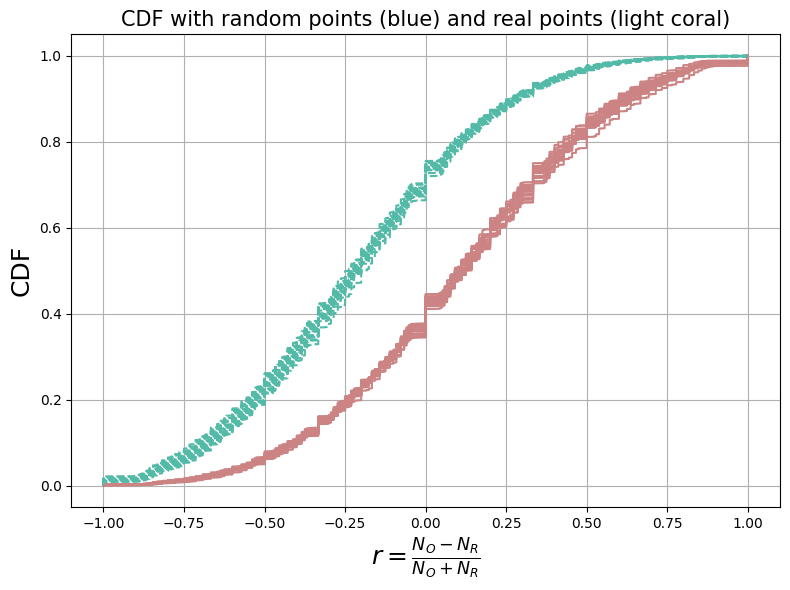

In [144]:
fig, ax = plt.subplots(figsize=(8, 6))

for key in data_all.keys():
    cdf_df = data_all[key]

    sort = cdf_df['r'].sort_values()
    sort_rand = cdf_df[cdf_df['type'] == 'rand'].sort_values(by='r')
    sort_data = cdf_df[cdf_df['type'] == 'data'].sort_values(by='r')

    cdf = np.arange(1, len(sort)+1) / len(sort)
    cdf_rand = np.arange(1, len(sort_rand['r'])+1) / len(sort_rand['r'])
    cdf_data = np.arange(1, len(sort_data['r'])+1) / len(sort_data['r'])

    ax.plot(sort_data['r'], cdf_data, color = '#cc8383')
    ax.plot(sort_rand['r'], cdf_rand, linestyle='--',color='#52baa7')

ax.set_xlabel(r'$r = \frac{N_O - N_R}{N_O + N_R}$', fontsize=18)
ax.set_ylabel('CDF', fontsize=18)
ax.grid(True)
plt.title('CDF with random points (blue) and real points (light coral)',size=15)
plt.tight_layout()
plt.show()

## Visualization

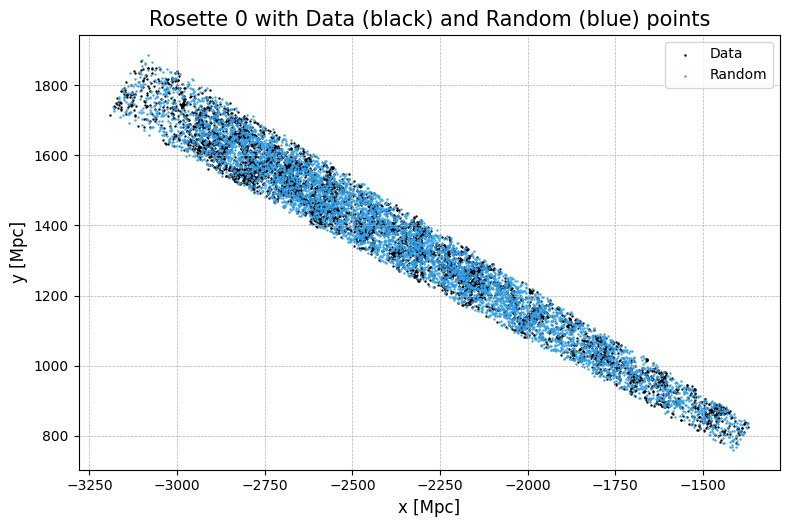

In [151]:
fig, ax = plt.subplots(figsize=(8, 6))

data_tri = "data_0"
rand_tri = "rand_0"

ax.scatter(data[data_tri]['x'], data[data_tri]['y'], c='k', s=0.5, label='Data')
ax.scatter(rand[rand_tri]['x'], rand[rand_tri]['y'], c='#32A1EA', s=0.5, label='Random')

ax.set_xlabel('x [Mpc]', size=12)
ax.set_ylabel('y [Mpc]', size=12)
ax.set_aspect('equal', adjustable='box')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_title('Rosette 0 with Data (black) and Random (blue) points', fontsize=15, y=1.001)

ax.legend()
plt.tight_layout()
plt.show()

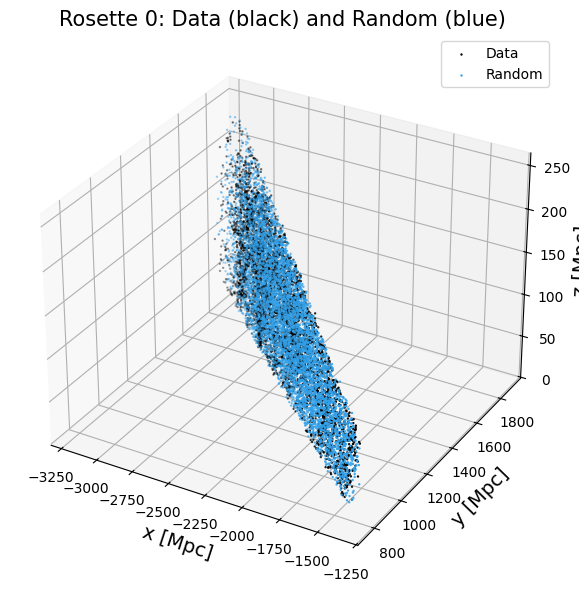

In [156]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # necesario para 3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

data_tri = "data_0"
rand_tri = "rand_0"


ax.scatter(data[data_tri]['x'], data[data_tri]['y'], data[data_tri]['z'], c='k', s=0.5, label='Data')
ax.scatter(rand[rand_tri]['x'], rand[rand_tri]['y'], rand[rand_tri]['z'], c='#32A1EA', s=0.5, label='Random')

ax.set_xlabel('x [Mpc]', size=14)
ax.set_ylabel('y [Mpc]', size=14)
ax.set_zlabel('z [Mpc]', size=14)
ax.set_title('Rosette 0: Data (black) and Random (blue)', fontsize = 15)
ax.legend()

plt.tight_layout()
plt.show()


### Alignment

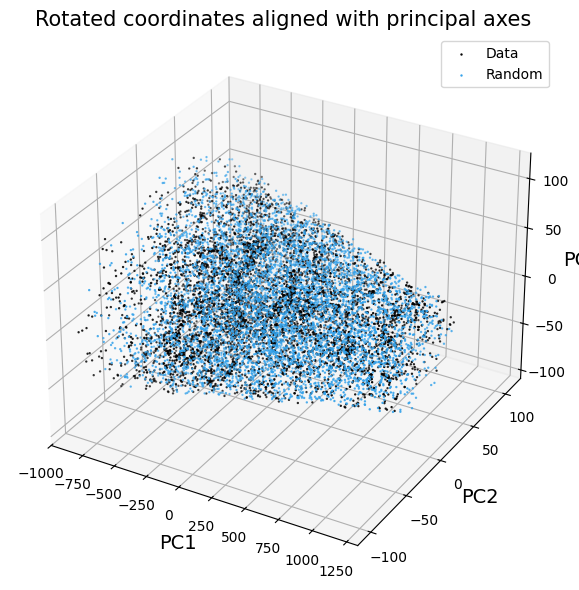

In [163]:
pca = PCA(n_components=3)

coords = data[data_tri][['x', 'y', 'z']].values
coords_rotated = pca.fit_transform(coords)

rand_coords = rand[rand_tri][['x', 'y', 'z']].values
rand_rotated = pca.transform(rand_coords)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(coords_rotated[:, 0], coords_rotated[:, 1], coords_rotated[:, 2],
           c='k', s=0.5, label='Data')

ax.scatter(rand_rotated[:, 0], rand_rotated[:, 1], rand_rotated[:, 2],
           c='#32A1EA', s=0.5, label='Random')

ax.set_xlabel('PC1', size=14)
ax.set_ylabel('PC2', size=14)
ax.set_zlabel('PC3', size=14)
ax.set_title('Rotated coordinates aligned with principal axes', fontsize=15)
ax.legend()

plt.tight_layout()
plt.show()


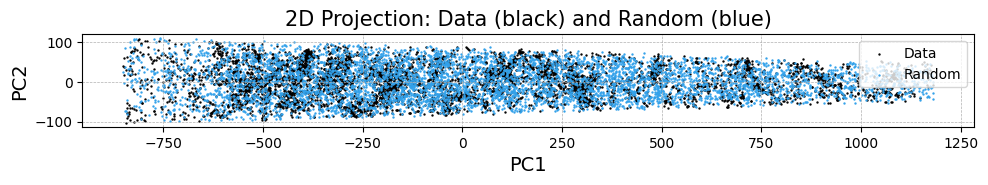

In [164]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(coords_rotated[:, 0], coords_rotated[:, 1], c='k', s=0.5, label='Data')
ax.scatter(rand_rotated[:, 0], rand_rotated[:, 1], c='#32A1EA', s=0.5, label='Random')

ax.set_xlabel('PC1', fontsize=14)
ax.set_ylabel('PC2', fontsize=14)
ax.set_aspect('equal', adjustable='box')
ax.grid(True, linestyle='--', linewidth=0.5)
ax.legend()
ax.set_title('2D Projection: Data (black) and Random (blue)', fontsize=15)

plt.tight_layout()
plt.show()


In [168]:
key = 'rosette_0'

data_filtered_real = data_all[key][data_all[key]['type'] == 'data']
data_filtered_rand = data_all[key][data_all[key]['type'] == 'rand']

In [171]:
# Primero clasificamos
void_real, sheet_real, filament_real, knot_real = mask_classification(data_filtered_real)
void_rand, sheet_rand, filament_rand, knot_rand = mask_classification(data_filtered_rand)

classified = {
    'void_real': void_real,
    'sheet_real': sheet_real,
    'filament_real': filament_real,
    'knot_real': knot_real,
    'void_rand': void_rand,
    'sheet_rand': sheet_rand,
    'filament_rand': filament_rand,
    'knot_rand': knot_rand
}

coords_rotated = {}

for name, df in classified.items():
    coords = df[['x', 'y', 'z']].values
    pca = PCA(n_components=3)
    coords_rot = pca.fit_transform(coords)
    coords_rotated[name] = coords_rot

In [180]:
sheet_real.min()

TARGETID          39627799312470444
RA                       148.369303
DEC                        0.471382
Z                          0.400228
x                      -3179.152338
y                        783.313845
z                         15.455771
type                           data
degree                          5.0
N_data                            0
N_random                          0
r                              -1.0
classification                sheet
dtype: object

In [181]:
coords_rot.min()

-712.7071618296534

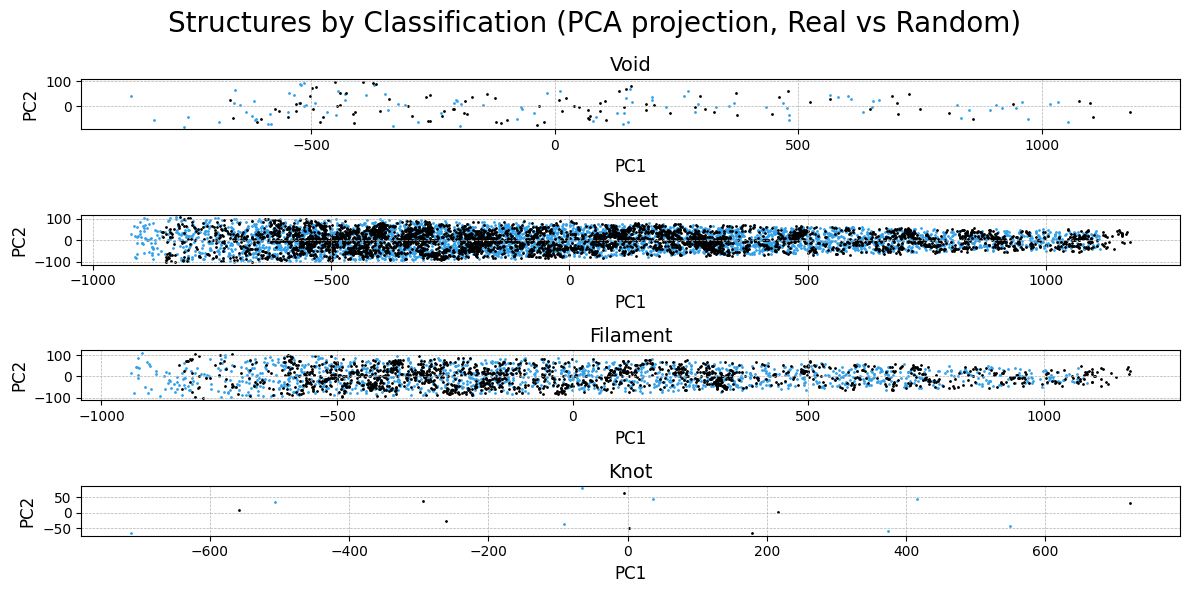

In [178]:
classes = ['void', 'sheet', 'filament', 'knot']
titles = ['Void', 'Sheet', 'Filament', 'Knot']

fig, ax = plt.subplots(4, 1, figsize=(12, 6))
axes = ax.flatten()

for i in range(4):
    structure = classes[i]

    coords_real = coords_rotated[f'{structure}_real']
    coords_rand = coords_rotated[f'{structure}_rand']

    axes[i].scatter(coords_rand[:, 0], coords_rand[:, 1], c='#32A1EA', s=1, label='Random')
    axes[i].scatter(coords_real[:, 0], coords_real[:, 1], c='k', s=1, label='Real')

    axes[i].set_title(titles[i], fontsize=14)
    axes[i].set_xlabel('PC1', size=12)
    axes[i].set_ylabel('PC2', size=12)
    axes[i].grid(True, linestyle='--', linewidth=0.5)

fig.suptitle('Structures by Classification (PCA projection, Real vs Random)', fontsize=20)
plt.tight_layout()
plt.show()


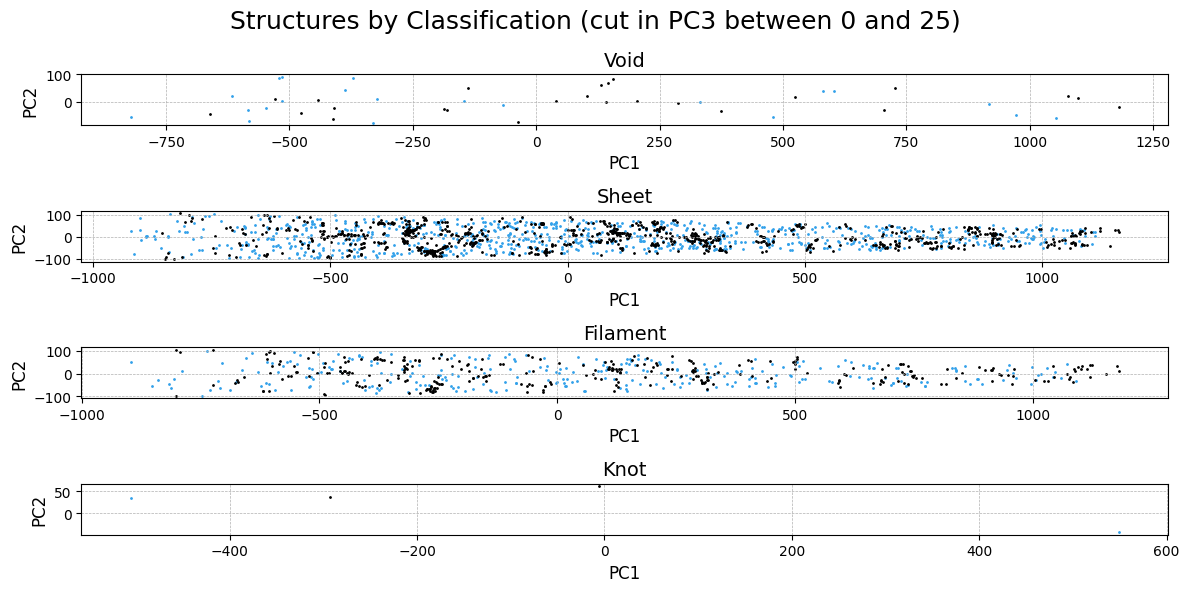

In [186]:
pc3_slice = (0,25)  

classes = ['void', 'sheet', 'filament', 'knot']
titles = ['Void', 'Sheet', 'Filament', 'Knot']

fig, ax = plt.subplots(4, 1, figsize=(12, 6))
axes = ax.flatten()

for i in range(4):
    structure = classes[i]

    coords_real = coords_rotated[f'{structure}_real']
    coords_rand = coords_rotated[f'{structure}_rand']

    mask_real = (coords_real[:, 2] >= pc3_slice[0]) & (coords_real[:, 2] <= pc3_slice[1])
    mask_rand = (coords_rand[:, 2] >= pc3_slice[0]) & (coords_rand[:, 2] <= pc3_slice[1])

    coords_real_cut = coords_real[mask_real]
    coords_rand_cut = coords_rand[mask_rand]

    axes[i].scatter(coords_rand_cut[:, 0], coords_rand_cut[:, 1], c='#32A1EA', s=1, label='Random')
    axes[i].scatter(coords_real_cut[:, 0], coords_real_cut[:, 1], c='k', s=1, label='Real')

    axes[i].set_title(titles[i], fontsize=14)
    axes[i].set_xlabel('PC1', size=12)
    axes[i].set_ylabel('PC2', size=12)
    axes[i].grid(True, linestyle='--', linewidth=0.5)

fig.suptitle(f'Structures by Classification (cut in PC3 between {pc3_slice[0]} and {pc3_slice[1]})', fontsize=18)
plt.tight_layout()
plt.show()


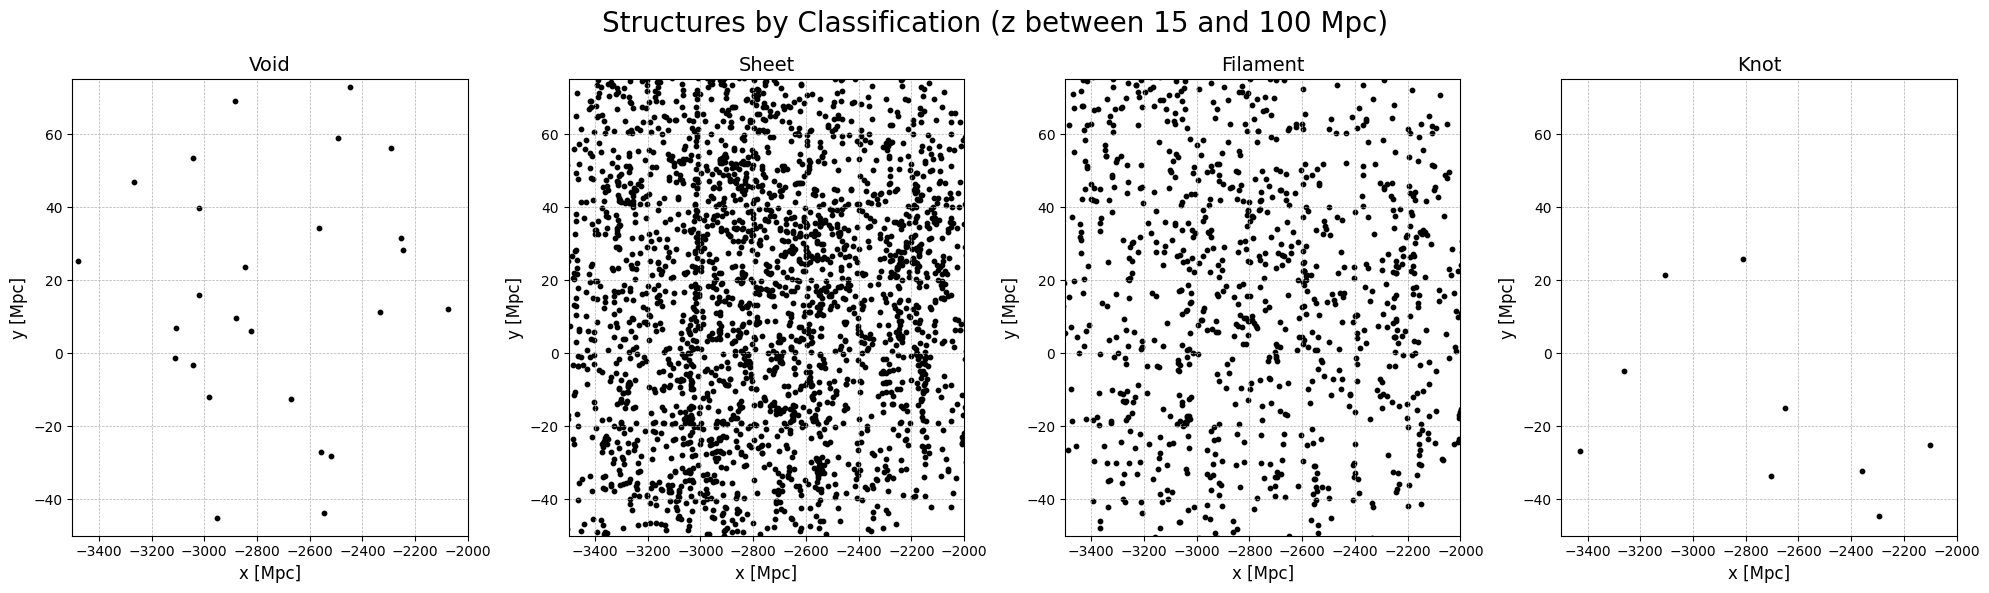

In [90]:
z_slice = (15, 100) 

fig, ax = plt.subplots(1, 4, figsize=(20, 6))
axes = ax.flatten()

classes = [void, sheet, filament, knot]
titles = ['Void', 'Sheet', 'Filament', 'Knot']

for i in range(4):
    mask_z = (classes[i]['z'] >= z_slice[0]) & (classes[i]['z'] <= z_slice[1])
    data_filtered = classes[i][mask_z]

    axes[i].scatter(data_filtered['x'], data_filtered['y'], c='k', s=10)
    axes[i].set_title(titles[i], fontsize=14)
    axes[i].set_xlabel('x [Mpc]', size=12)
    axes[i].set_ylabel('y [Mpc]', size=12)
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[i].set_xlim(-3500,-2000)
    axes[i].set_ylim(-50,75)

fig.suptitle(f'Structures by Classification (z between {z_slice[0]} and {z_slice[1]} Mpc)', fontsize=20)
plt.tight_layout()
plt.show()

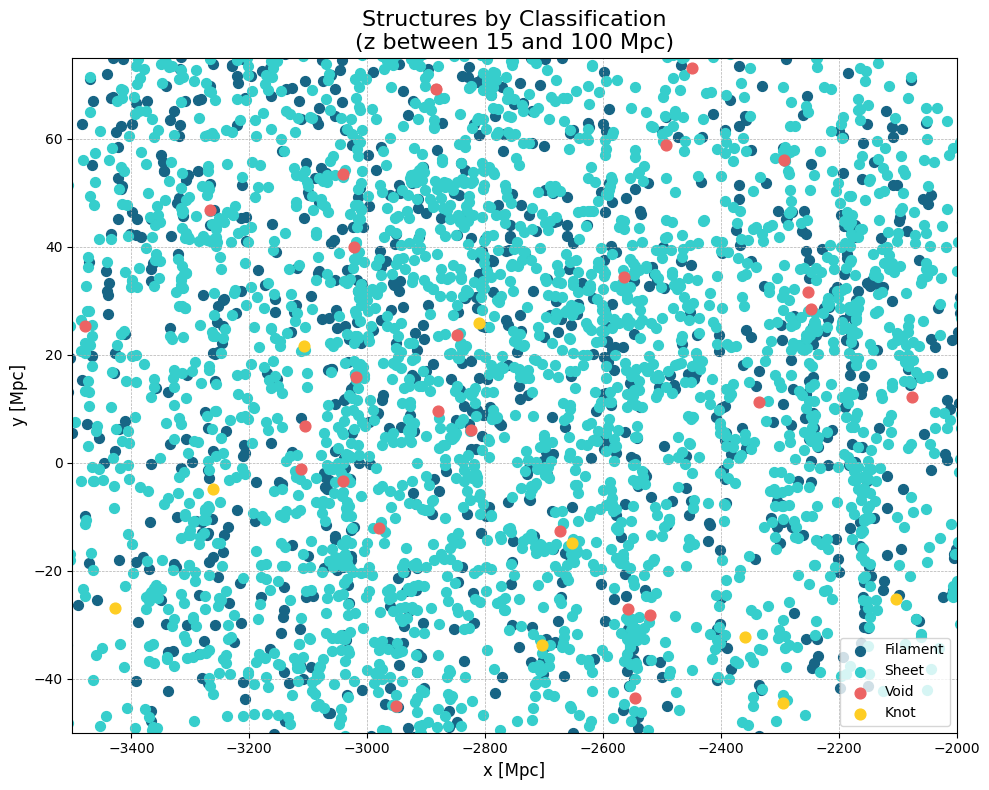

In [117]:
void_filtered = void[(void['z'] >= z_slice[0]) & (void['z'] <= z_slice[1])]
sheet_filtered = sheet[(sheet['z'] >= z_slice[0]) & (sheet['z'] <= z_slice[1])]
filament_filtered = filament[(filament['z'] >= z_slice[0]) & (filament['z'] <= z_slice[1])]
knot_filtered = knot[(knot['z'] >= z_slice[0]) & (knot['z'] <= z_slice[1])]

fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(filament_filtered['x'], filament_filtered['y'], c='#176585', s=50, label='Filament')     
ax.scatter(sheet_filtered['x'], sheet_filtered['y'], c='#36cecc', s=50, label='Sheet')             
ax.scatter(void_filtered['x'], void_filtered['y'], c='#ec6363', s=60, label='Void', zorder=3)       
ax.scatter(knot_filtered['x'], knot_filtered['y'], c='#fecd23', s=60, label='Knot', zorder=4)  




ax.set_xlabel('x [Mpc]', size=12)
ax.set_ylabel('y [Mpc]', size=12)
ax.set_title(f'Structures by Classification\n(z between {z_slice[0]} and {z_slice[1]} Mpc)', fontsize=16)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(fontsize=10)
ax.set_xlim(-3500,-2000)
ax.set_ylim(-50,75)

plt.tight_layout()
plt.show()